In [1]:
#import all the libraries
import matplotlib.image as mpimage
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
# from lesson_function import *
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline


In [2]:
#load training cars and nocars images
cars = glob.glob('./dataset/vehicles/*/*.png')
nocars = glob.glob('./dataset/non-vehicles/*/*.png')
print('The number of cars images: ',len(cars))
print('The number of no-cars images',len(nocars))

The number of cars images:  8792
The number of no-cars images 8968


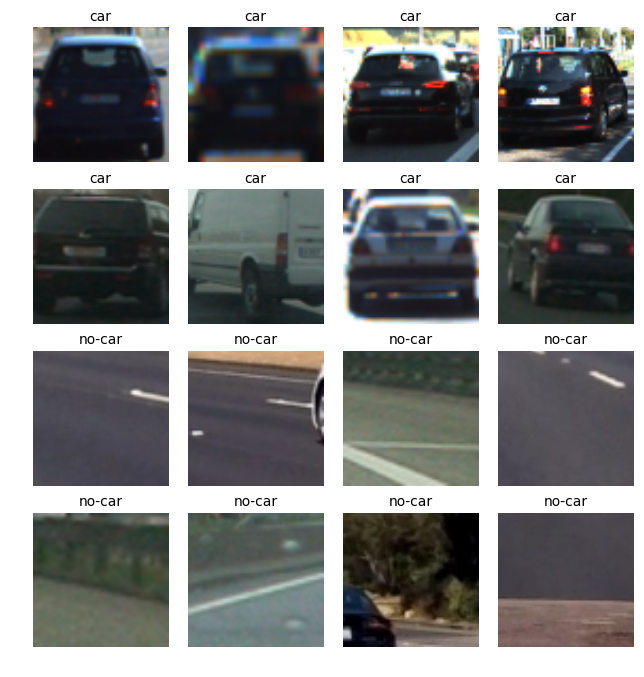

In [3]:
#visualize some data
fig,axs = plt.subplots(4,4,figsize=(8,8))
fig.subplots_adjust(hspace=0.2,wspace=0.001)
axs = axs.ravel()

for i in np.arange(8):
    img = cv2.imread(cars[np.random.randint(0,len(cars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
#     print(img.shape)
    axs[i].axis('off')
    axs[i].set_title('car',fontsize=10)
    axs[i].imshow(img)
for i in np.arange(8,16):
    img = cv2.imread(nocars[np.random.randint(0,len(nocars))])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    axs[i].axis('off')
    axs[i].set_title('no-car',fontsize=10)
    axs[i].imshow(img)

In [4]:
##HOG function
#Define a function to extract hog feature of an image
def get_hog_feature(img,orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True):
    if vis == True:
        features,hog_image = hog(img,orientations=orient,
                                                    pixels_per_cell=(pix_per_cell,pix_per_cell),
                                                    cells_per_block=(cell_per_block,cell_per_block),
                                                    transform_sqrt=True,
                                                    visualise=vis,feature_vector=feature_vec)
        return features,hog_image
    else:
            features = hog(img,orientations=orient,
                                      pixels_per_cell=(pix_per_cell,pix_per_cell),
                                      cells_per_block=(cell_per_block,cell_per_block),
                                      transform_sqrt=True,visualise=vis,feature_vector=feature_vec)
#             print('in get_hog_feature,Image Shape is: ',img.shape,' Feature size is : ',features.shape,' orient is: ',orient)
            return features

In [5]:
# skimage hog test
hog_feat = True
color_space = 'HLS'
orient = 11
pix_per_cell = 9
cell_per_block = 2
hog_channel = 'ALL'

myimg = mpimage.imread(test_imgs[0])
myimg = myimg[1:65,1:65,0]

hog_feature = hog(myimg,orientations=11,pixels_per_cell=(9,9),cells_per_block=(2,2),
                                 transform_sqrt=True,visualise=False,feature_vector=True)
print(myimg.shape)
print(hog_feature.shape)
    

NameError: name 'test_imgs' is not defined

In [6]:
#Define a function to extract binned color features 
def bin_spatial(img,size=(32,32)):
    #Use cv2.resize().ravel() to create the feature vector 
    features = cv2.resize(img,size).ravel()
    return features


In [7]:
#Define a function to compute color histogram features
def color_hist(img,nbins=32,bins_range=(0,256)):
    #Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0],bins=nbins,range=bins_range)
    channel2_hist = np.histogram(img[:,:,1],bins=nbins,range=bins_range)
    channel3_hist = np.histogram(img[:,:,2],bins=nbins,range=bins_range)
    
    #Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0],channel2_hist[0],channel3_hist[0]))
    return hist_features
    

In [8]:
#Define a funcion to extract features from an image,include binned color feature,color histogram feature and hog feature
def extract_features(img,color_space='RGB',spatial_size=(32,32),
                                    hist_bins=32,orient=11,
                                    pix_per_cell=8,cell_per_block=2,hog_channel=0,
                                    spatial_feat=True,hist_feat=True,hog_feat=True):
    #Create a list to append feature vectors to
    features = []
    
    # Apply color conversion if other color space than 'RGB
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YUV':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_img = cv2.cvtColor(img,cv2.COLOR_RGB2YCrCb)
    else:
        feature_img = np.copy(img)
    
    #For debug
#     flag = True
      
    
    # Add spatial feature or not
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_img,size=spatial_size)
        features.append(spatial_features)
   
    #Add color hist feature or not
    if hist_feat == True:
        hist_features = color_hist(feature_img,nbins=hist_bins)
        features.append(hist_features)
        
#         if flag == True:
#             print('Debug: Shape of hist feature: ',hist_features.shape)
            
    # Add hog feature or not
    if hog_feat == True:
        # Add all channels features or only one
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_img.shape[2]):
                hog_feature = get_hog_feature(feature_img[:,:,channel],
                                                                                orient,pix_per_cell,cell_per_block,vis=False,feature_vec=True)
#                 print('channel: %d, shape of feature: ',channel,hog_feature.shape)
                hog_features.append(hog_feature)
                
            hog_features = np.ravel(hog_features)
        else:
            hog_features = get_hog_feature(feature_img[:,:,hog_channel],
                                                                   orient,pix_per_cell,cell_per_block,
                                                                    vis=False,feature_vec=True)
    features.append(hog_features)
        
#         return features   
    return np.concatenate(features)
    

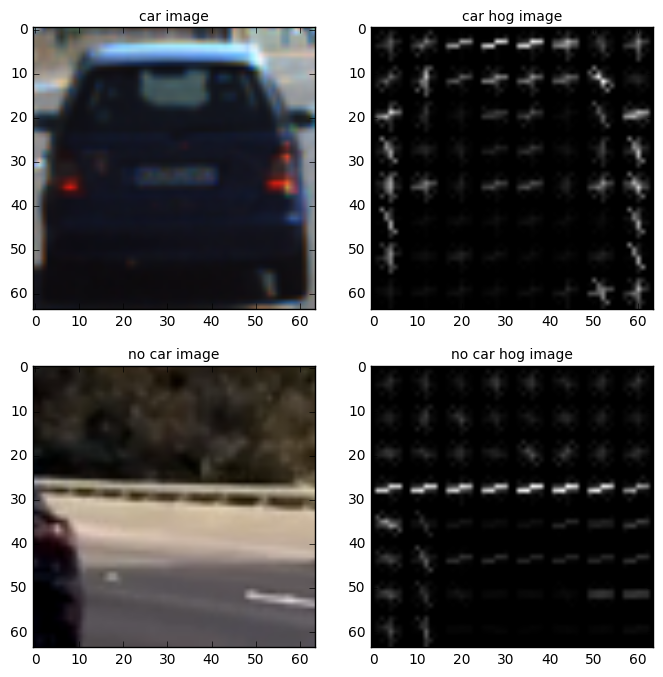

In [9]:
#Visualize HOG feature of car image and non-car image
car_img = cv2.imread(cars[np.random.randint(0,len(cars))])
car_img = cv2.cvtColor(car_img,cv2.COLOR_BGR2RGB)
# car_img = mpimage.imread(cars[np.random.randint(0,len(cars))])
_,car_hog_img = get_hog_feature(car_img[:,:,0],9,8,2,vis=True,feature_vec=True)

no_car_img = cv2.imread(nocars[np.random.randint(0,len(nocars))])
no_car_img = cv2.cvtColor(no_car_img,cv2.COLOR_BGR2RGB)
# no_car_img = mpimage.imread(cars[np.random.randint(0,len(nocars))])
_,no_car_hog_img = get_hog_feature(no_car_img[:,:,2],9,8,8,vis=True,feature_vec=True)


fig,axs = plt.subplots(2,2,figsize=(8,8))
fig.subplots_adjust(hspace=0.2,wspace=0.2)
axs = axs.ravel()
axs[0].imshow(car_img)
axs[0].set_title('car image',fontsize=10)
axs[1].imshow(car_hog_img,cmap='gray')
axs[1].set_title('car hog image',fontsize=10)

axs[2].imshow(no_car_img)
axs[2].set_title('no car image',fontsize=10)
axs[3].imshow(no_car_hog_img,cmap='gray')
axs[3].set_title('no car hog image',fontsize=10)


In [10]:
#Extract all the images features.Shuffle and split
#HOG parameters setting
hog_feat = True
color_space = 'HLS'
orient = 11
pix_per_cell = 9
cell_per_block = 2
hog_channel = 'ALL'

#binned spatial feature parameter
spatial_feat = True
spatial_size = (16,16)

#Color histogram feature parameter
hist_feat = True
hist_bins = 32

#Measure time for extracting all the features
t1 = time.time()

#Car feature list and non-car feature list
all_car_features = []
all_non_car_features = []

for imgpath in cars:
    car_img = mpimage.imread(imgpath)
    car_feature = extract_features(car_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                                    pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                     spatial_feat=True,hist_feat=True,hog_feat=True )
    all_car_features.append(car_feature)

print(len(all_car_features))
    
for imgpath in nocars:
    no_car_img = mpimage.imread(imgpath)
    no_car_feature = extract_features(no_car_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,orient=orient,
                                                    pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,hog_channel=hog_channel,
                                                     spatial_feat=True,hist_feat=True,hog_feat=True )
    all_non_car_features.append(no_car_feature)

t2 = time.time()
print('Extracting features consumes ',round(t2-t1,2),' seconds')

print('The length of car features: ',len(all_car_features))
print('The lengthe of not-car features: ',len(all_non_car_features))

#Stack car features and not-car features together
all_features = np.vstack((all_car_features,all_non_car_features)).astype(np.float64)
print('The lengthe of all features: ',len(all_features))

#Fit a per-column scaler
scaler = StandardScaler().fit(all_features)
all_features_scaled = scaler.transform(all_features)

#Define labels vector
labels = np.hstack((np.ones(len(all_car_features)),np.zeros(len(all_non_car_features)))).astype(np.float64)
print('The length of all lables',len(labels))

#Split data into randomized training and test sets
rand_state = np.random.randint(0,100)
x_train,x_test,y_train,y_test = train_test_split(all_features_scaled,labels,test_size=0.2,random_state=rand_state)

print('The length of training dataset: ',len(x_train))
print('The length of test datast',len(y_train))

8792
Extracting features consumes  57.47  seconds
The length of car features:  8792
The lengthe of not-car features:  8968
The lengthe of all features:  17760
The length of all lables 17760
The length of training dataset:  14208
The length of test datast 14208


In [11]:
#Create a linear classifier
svc = LinearSVC()

#Measure training time
t1 = time.time()
svc.fit(x_train,y_train)
t2 = time.time()

print('Training time : ',round(t2-t1,2),'seconds')

#Check the score of SVC classifier
print('Training Accuracy of SVC ',svc.score(x_train,y_train))
print('Test Accuracy of SVC: ',svc.score(x_test,y_test))

#Check the prediction time
t1 = time.time()
num_predict = 10
print('SVC Predict: ',svc.predict(x_train[0:num_predict]))
print('Real label: ',y_train[0:num_predict])
t2 = time.time()
print(round(t2-t1,2),' seconds used to pridicet ',num_predict,' samples')

Training time :  5.21 seconds
Training Accuracy of SVC  1.0
Test Accuracy of SVC:  0.988175675676
SVC Predict:  [ 1.  0.  1.  0.  1.  1.  0.  1.  1.  0.]
Real label:  [ 1.  0.  1.  0.  1.  1.  0.  1.  1.  0.]
0.0  seconds used to pridicet  10  samples


In [12]:
#Random Test SVC Acuracy
idx = np.random.randint(len(x_test),size=40)
print(idx)
print('SVC Predict: ',svc.predict(x_test[idx]))
print('Real label: ',y_test[idx])

print(np.equal(svc.predict(x_train[idx]),y_train[idx]))  
# print('Accuracy is: ',np.mean(np.sum(np.equal(svc.predict(idx),y_train[idx]))))


[ 272 2499 2417 1082  637 2378 1744  184 1548  346 1685 2347 3396 3158 2204
 2376 2439 2787 2491 1695 1643 2591 2189 3313 2886 2798 2885 2882 2488 1753
 3336 1629 2983 3212 2986  305 1909 2079 1921 1113]
SVC Predict:  [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  1.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  0.  0.]
Real label:  [ 0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.  0.  0.
  1.  0.  0.  0.  0.  0.  1.  0.  1.  0.  0.  1.  0.  1.  1.  1.  1.  1.
  1.  1.  0.  0.]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]


In [13]:
#Save data and trained SVC model
pickle_file = 'train_test_data.p'
try:
    with open(pickle_file,'wb') as pfile:
        pickle.dump(
                            {
                                'x_train':x_train,
                                'y_train':y_train,
                                'x_test':x_test,
                                'y_test':y_test
                            } ,
                            pfile,pickle.HIGHEST_PROTOCOL
                            )
except Exception as e:
    print('Unable to save data,error happens: ',e)
    raise
print('Training and test data saved')

pickle_file = 'svc_classifier.p'
try:
    with open(pickle_file,'wb') as pfile:
        pickle.dump(
                            {'svc':svc},pfile,pickle.HIGHEST_PROTOCOL
                            )
except Exception as e:
    print('Error happens:',e)
    raise
print('SVC saved')

Training and test data saved
SVC saved


Size of test_image :  (720, 1280, 3)
Image dtype: float32


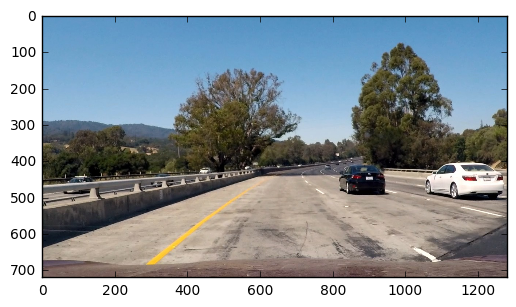

In [14]:
#Explore the test image
test_imgs = glob.glob('./test_images/*.jpg')
# print(test_imgs)
test_img = mpimage.imread(test_imgs[0])
print('Size of test_image : ',test_img.shape)

test_img = test_img.astype(np.float32)/255

plt.imshow(test_img)
print('Image dtype:',test_img.dtype)


In [225]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img,x_start_stop=[None,None],y_start_stop=[None,None],
                            window_size=(64,54),overlap_size=(0.5,0.5)):
    # If x or y start and stop positions not defined,set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    
    #Compute the span of the region to be searched
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    
    #Compute the number of pixels per step in x and y direciton
    nx_pix_per_step = np.int(window_size[0] * (1 - overlap_size[0]))
    ny_pix_per_step = np.int(window_size[1] * (1 - overlap_size[1]))
    
    #Computer the number of window in x and y direction
    nx_windows = np.int(xspan/nx_pix_per_step) - 1
    ny_windows = np.int(yspan/ny_pix_per_step) - 1
    
    #Create a list to put all windows into
    window_list = []
    #Loop through finding x and y window positions
    #Note: you can vectorize this step, but in practice,you'll be considering windows one by one with
    # classifier,so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            #Calculate window positon
            startx = int(xs*nx_pix_per_step + x_start_stop[0])
            endx = int(startx + window_size[0])
            starty = int(ys*ny_pix_per_step + y_start_stop[0])
            endy = int(starty + window_size[1])
            
            window_list.append(((startx,starty),(endx,endy)))
    
    return window_list
      
       

In [226]:
#For debug 
pre_true = 0

In [227]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img,windows,clf,scaler,color_space='RGB',
                                  spatial_size=(16,16),hist_bins=32,
                                  hist_range=(0,256),orient=11,pix_per_cell=9,cell_per_block=2,
                                  hog_channel=0,spatial_feat=True,
                                  hist_feat=True,hog_feat=True):
    #Create an empty list to receive positive detection windows
    on_windows = []
    
    #For debug 
    flag = True
        
    #Iterate over all windows in the list
    for window in windows:
        # Resize the ROI image 
        roi_img = cv2.resize(img[window[0][1]:window[1][1],window[0][0]:window[1][0]],(64,64))
        # Extract features for the resized ROI window
        roi_features = extract_features(roi_img,color_space=color_space,
                                                   spatial_size=spatial_size,hist_bins=hist_bins,
                                                   pix_per_cell=pix_per_cell,cell_per_block=cell_per_block,
                                                   hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                   hist_feat=hist_feat,hog_feat=hog_feat)
        # Use sklearn.StandardScaler to transform the features
        roi_features = scaler.transform(np.array(roi_features).reshape(1,-1))
        
#         print('Shape of roi_features : ',roi_features.shape)
#         roi_features = scaler.transform(roi_features)
        #Predict using svc classifier
        
        prediction = clf.predict(roi_features)
        
        if prediction == 1 :
            on_windows.append(window)
            global pre_true
            pre_true += 1
#             plt.figure()
#             plt.imshow(roi_img)
        
    #Return windows for positive detections
    return on_windows
        


In [228]:
#Define a function to search windows in a full image,get all the windows that may have a car
def search_all_scales(img,classifier=None):
    hot_windows = []
    all_windows = []
    
    x_start_stop = [[None,None],[None,None],[None,None],[None,None]]
    #window size
    w0,w1,w2,w3 = 240,180,120,70
    # overlap percentage
    o0,o1,o2,o3 = 0.75,0.75,0.75,0.75
    window_size = [(w0,w0),(w1,w1),(w2,w2),(w3,w3)]
    overlap_size = [(o0,o0),(o1,o1),(o2,o2),(o3,o3)]
    yi0,yi1,yi2,yi3 = 380,380,395,405
#     yi0,yi1,yi2,yi3 = 350,350,380,380
    y_start_stop = [[yi0,yi0+w0/2],[yi1,yi1+w1/2],[yi2,yi2+w2/2],[yi3,yi3+w3/2]]
#     y_start_stop = [[yi0,yi0+w0],[yi1,yi1+w1],[yi2,yi2+w2],[yi3,yi3+w3]]
    
    for i in range(len(y_start_stop)):
        windows = slide_window(img,x_start_stop=x_start_stop[i],y_start_stop=y_start_stop[i],
                                              window_size=window_size[i],overlap_size=overlap_size[i])
        all_windows += [windows]
#         print('in search all scale:',type(classifier))
        hot_windows += search_windows(img,windows,classifier,scaler,color_space=color_space,
                                                         spatial_size=spatial_size,hist_bins=hist_bins,
                                                         orient=orient,pix_per_cell=pix_per_cell,
                                                         cell_per_block=cell_per_block,
                                                         hog_channel=hog_channel,spatial_feat=spatial_feat,
                                                         hist_feat=hist_feat,hog_feat=hog_feat)
        
    return hot_windows,all_windows      
    
        

In [229]:
# Draw bounding boxes function
def draw_boxes(img,bboxes,color=(0,0,255),thick=6):
    #make a copy of the image
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy,bbox[0],bbox[1],color,thick)
    return imcopy

4
len of hot windows:  0
number of all windows:  162
pre_true:  0


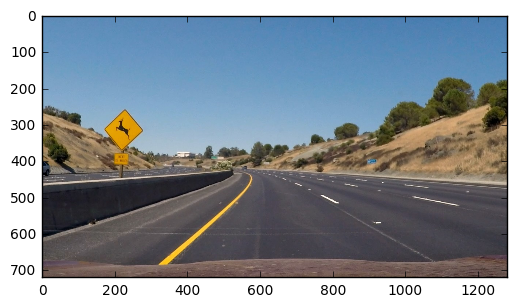

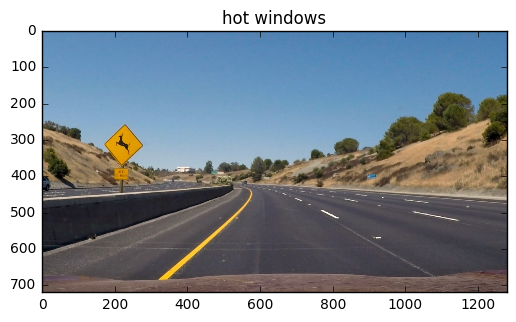

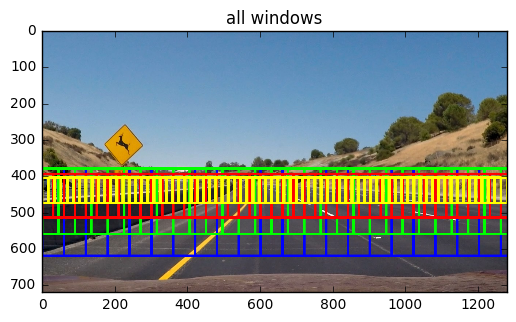

In [230]:
#HOG parameters setting
hog_feat = True
color_space = 'HLS'
orient = 11
pix_per_cell = 9
cell_per_block = 2
hog_channel = 'ALL'

#binned spatial feature parameter
spatial_feat = True
spatial_size = (16,16)

#Color histogram feature parameter
hist_feat = True
hist_bins = 32

with open('svc_classifier.p',mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc']

test_imgs = glob.glob('./test_images/*.jpg')

test_img1 = mpimage.imread(test_imgs[2])

test_img_float = test_img1.astype(np.float32)/255
# plt.imshow(mpimage.imread(test_imgs[0]))

hot_windows,all_windows = search_all_scales(test_img_float,classifier=svc)
print(len(all_windows))
# print(all_windows[0])
# allwindows_img =np.int32(np.copy(test_img1)) 
# print(allwindows_img[:1,:1,:])
print('len of hot windows: ',len(hot_windows))
print('number of all windows: ',len(all_windows[0])+len(all_windows[1])+len(all_windows[2])+len(all_windows[3]))
print('pre_true: ',pre_true)

plt.imshow(test_img1)

window_img = np.copy(test_img1)
window_img = draw_boxes(window_img, hot_windows, color=(0, 0, 255), thick=4)          
plt.figure()
plt.imshow(window_img)
plt.title('hot windows')

allwindows_img = np.copy(test_img1)
for ind,win_list in enumerate(all_windows):
        if ind==0: color= (0,0,255)
        if ind==1: color= (0,255,0)
        if ind==2: color= (255,0,0)
        if ind==3: color= (255,255,0)
        
        #allwindows_img is wrong,why?
        #         allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)   
        allwindows_img = draw_boxes(allwindows_img, all_windows[ind], color=color, thick=6)         
plt.figure()
plt.imshow(allwindows_img)
plt.title('all windows')


In [231]:
#Heatmap
#Heatmap is used to filter wrong boxes
def add_heat(heatmap,bboxes):
    for box in bboxes:
        #Add 1 for all pixels inside each box
        # Assuming each box takes the form ((x1,y1),(x2,y2))
        heatmap[box[0][1]:box[1][1],box[0][0]:box[1][0]] += 1
    return heatmap


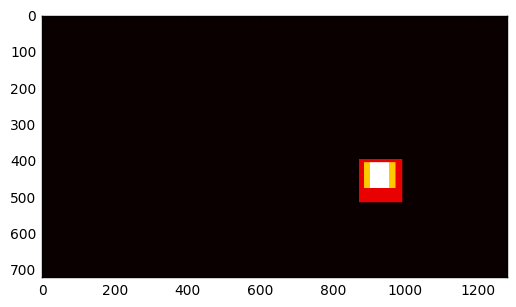

In [236]:
# Test add_heat function
test_imgs = glob.glob('./test_images/*.jpg')
test_img1 = mpimage.imread(test_imgs[3])

test_img_float = test_img1.astype(np.float32)/255
hot_windows,all_windows = search_all_scales(test_img_float,classifier=svc)

# Make a heatmap
heatmap_img = np.zeros_like(test_img1[:,:,0])

Heatmap_img = add_heat(heatmap_img,hot_windows)
plt.imshow(heatmap_img,cmap='hot')

In [237]:
#Filter
#Apply threshold to filter out the wrong box
def apply_threshold(heatmap,threshold=2):
    #Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    return heatmap


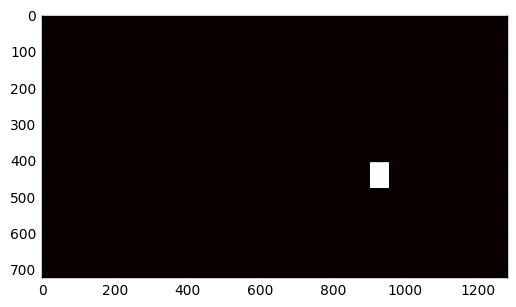

In [238]:
heatmap_img = apply_threshold(heatmap_img)
plt.imshow(heatmap_img,cmap='hot')

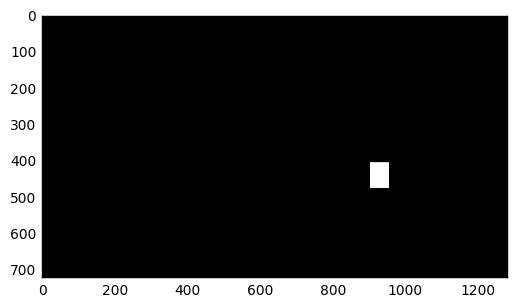

In [239]:
#Appley Scipy Labels to heatmap
labels = label(heatmap_img)
plt.imshow(labels[0],cmap='gray')

In [240]:
def draw_labeled_bboxes(img, labels):
    rects = []
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        rects.append(bbox)
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img,rects

uint8


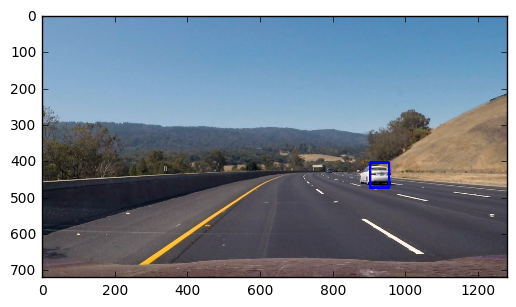

In [241]:
#Draw bounding box on a copy of the image
draw_img1,rects= draw_labeled_bboxes(np.copy(test_img1),labels)
print(draw_img1.dtype)
plt.imshow(draw_img1)


In [242]:
#Define a process function,put all the pipeline together
def process(img):
    float_img = img.astype(np.float32)/255
    # Note that img must be float type
    hot_windows,all_windows = search_all_scales(float_img,classifier=svc)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    heatmap_img = add_heat(heatmap_img,hot_windows)
    heatmap_img = apply_threshold(heatmap_img,2)
    labels = label(heatmap_img)
    draw_img1,rects= draw_labeled_bboxes(np.copy(img),labels)
    return draw_img1
    

uint8


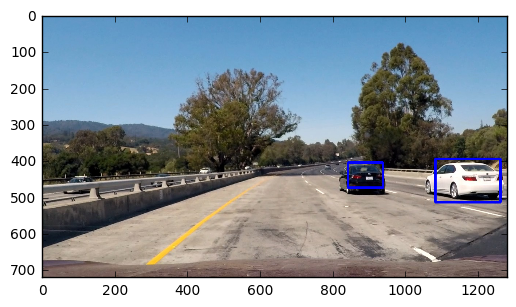

In [243]:
#Test process funtion
test_imgs = glob.glob('./test_images/*.jpg')

test_img1 = mpimage.imread(test_imgs[0])

# test_img_float = test_img1.astype(np.float32)/255
# Process input image is uint8 type,insice Process image is converted to float type
print(test_img1.dtype)
detect_img = process(test_img1)
plt.imshow(detect_img)

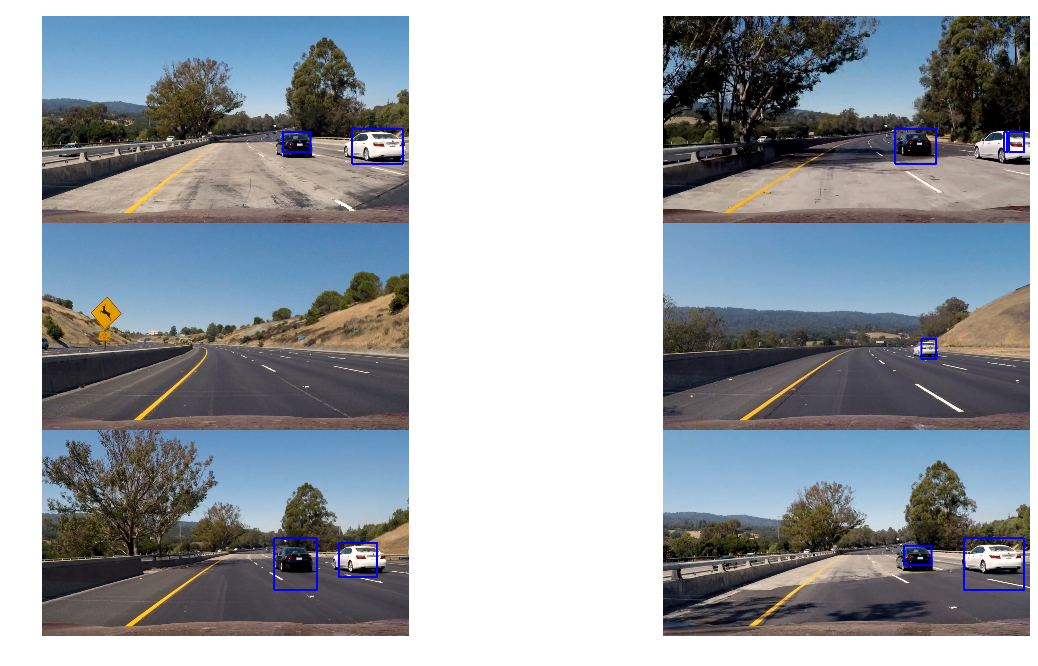

In [244]:
test_imgs = glob.glob('./test_images/*.jpg')
fig,axs = plt.subplots(3,2,figsize=(16,8))
fig.subplots_adjust(hspace=0.004,wspace=0.002)
axs = axs.ravel()

for i in np.arange(len(test_imgs)):
    img = mpimage.imread(test_imgs[i])
    axs[i].imshow(process(img))
    axs[i].axis('off')


In [245]:
#Process video through the pipeline
# one frame at a time with taking previous frames into account
#It if found that without taking account the fremes,detectiong rusult jitters a lot

out_dir = './output_images/'
input_video = './test_video.mp4'
out_filename = out_dir+'processed_video.mp4'
clip = VideoFileClip(input_video)
clip_out = clip.fl_image(process)
%time clip_out.write_videofile(out_filename,audio=False)


[MoviePy] >>>> Building video ./output_images/processed_video.mp4
[MoviePy] Writing video ./output_images/processed_video.mp4


 97%|█████████▋| 38/39 [00:17<00:00,  2.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_video.mp4 

CPU times: user 17.6 s, sys: 56 ms, total: 17.7 s
Wall time: 18.6 s


In [253]:
#Define a class to store previous detection results
# all these results can be used toghther to improve detection stablity.

class vehicle_detect():
    def __init__(self):
        #result rectanles of previous n frames
        self.prev_rects = []
        
    def add_rects(self,rects):
        self.prev_rects.append(rects)
        if len(self.prev_rects) > 15:
            #Throw out oldest rectangles,Like a quene data structure
            self.prev_rects = self.prev_rects[len(self.prev_rects)-15:]
        

In [254]:
#Define process_video function for process on video image
def process_video(img):
    float_img = img.astype(np.float32)/255
    # Note that img must be float type
    hot_windows,all_windows = search_all_scales(float_img,classifier=svc)
    
    #     heatmap_img = np.zeros_like(img[:,:,0])
    #     heatmap_img = add_heat(heatmap_img,hot_windows)
    #     heatmap_img = apply_threshold(heatmap_img,2)
    #     labels = label(heatmap_img)
    #     draw_img1,rects= draw_labeled_bboxes(np.copy(img),labels)
    
    if len(hot_windows) > 0:
        detec.add_rects(hot_windows)
    
    #define heatmap
    heatmap_img = np.zeros_like(img[:,:,0])
    #add heat to heatmap_img,ie.add one to pixels in rects
    for rects in detec.prev_rects:
        heatmap_img = add_heat(heatmap_img,rects)
    # Apply threshold to heatmap_img to filter out rects that appear rarely 
    heatmap_img = apply_threshold(heatmap_img,1+len(detec.prev_rects)//2)
    
    labels = label(heatmap_img)
    draw_img,rects = draw_labeled_bboxes(np.copy(img),labels)
    
    return draw_img
    
    
    
    

In [248]:
detec = vehicle_detect()
input_video = './test_video.mp4'
out_filename = './output_images/video_detect_result.mp4'
clip_test = VideoFileClip(input_video)
clip_test_out = clip_test.fl_image(process_video)
%time clip_test_out.write_videofile(out_filename,audio=False)

[MoviePy] >>>> Building video ./output_images/video_detect_result.mp4
[MoviePy] Writing video ./output_images/video_detect_result.mp4


 97%|█████████▋| 38/39 [00:18<00:00,  2.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/video_detect_result.mp4 

CPU times: user 18.5 s, sys: 132 ms, total: 18.7 s
Wall time: 19.8 s


In [251]:
HTML("""
<video width='720' height='540' controls>
<source src="{0}">
</video>
""".format(out_filename))

In [255]:
#Process the project video
proj_video = './project_video.mp4'
proj_outfile = './output_images/project_result.mp4'
clip_proj = VideoFileClip(proj_video)
clip_proj_out = clip_proj.fl_image(process_video)
%time clip_proj_out.write_videofile(proj_outfile,audio=False)


[MoviePy] >>>> Building video ./output_images/project_result.mp4
[MoviePy] Writing video ./output_images/project_result.mp4


100%|█████████▉| 1260/1261 [09:37<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/project_result.mp4 

CPU times: user 9min 31s, sys: 2.47 s, total: 9min 34s
Wall time: 9min 38s


In [ ]:
HTML("""
<video width='720' height='540' controls>
<source src="{0}">
</video>
""".format(proj_outfile))